In [1]:
from __future__ import print_function
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt

# For the imbalance of prospect and background, use dice loss
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1. - dice_coef(y_true, y_pred)


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1=BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1=BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2=BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2=BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3=BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3=BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4=BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4=BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5=BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5=BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    conv6=BatchNormalization()(conv6)  
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6=BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6=BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    conv7=BatchNormalization()(conv7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7=BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7=BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    conv8=BatchNormalization()(conv8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8=BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8=BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    conv9=BatchNormalization()(conv9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9=BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9=BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9=BatchNormalization()(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-3), loss = "binary_crossentropy", metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model



Using TensorFlow backend.


(181, 512, 512, 1)
(181, 512, 512, 1)


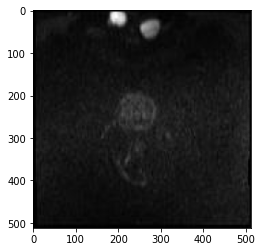

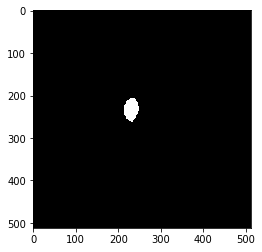

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
from glob import glob
import skimage.io as io
import skimage.transform as trans
import cv2


img_size = (512,512)

imgs=sorted(glob('./Prostate_Data/PCA_Seg/Image/*'))
labels=sorted(glob('./Prostate_Data/PCA_Seg/Mask/*'))



X_image = []
Y_label = []

for data in zip(imgs,labels):
    img=cv2.imread(data[0],0)
    img=cv2.resize(img,img_size)
    img = img.astype('float32') / 255.0
    mask=cv2.imread(data[1],0)
    mask=cv2.resize(mask,img_size)
    mask = mask.astype('float32') / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    

    
    X_image.append(img)
    Y_label.append(mask)
    
x_train=np.array(X_image).reshape((len(X_image),img_size[0],img_size[1],1))
y_train=np.array(Y_label).reshape((len(Y_label),img_size[0],img_size[1],1))


print (x_train.shape)
print (y_train.shape)


plt.imshow(x_train[0,:,:,0],cmap=plt.cm.gray)
plt.show()
plt.imshow(y_train[0,:,:,0],cmap=plt.cm.gray)
plt.show()

In [3]:
model=unet(input_size=(img_size[0],img_size[1],1))

model.fit(x_train,y_train,epochs=20,batch_size=2,validation_split=0.2)

/home/ilab/anaconda2/envs/Dinghow/lib/python2.7/site-packages/ipykernel_launcher.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

Train on 144 samples, validate on 37 samples
Epoch 1/20
144/144 [==============================] - 47s 326ms/step - loss: 0.6322 - acc: 0.9600 - val_loss: 2.3700 - val_acc: 0.2383
Epoch 2/20
144/144 [==============================] - 38s 263ms/step - loss: 0.5432 - acc: 0.9843 - val_loss: 0.7779 - val_acc: 0.8209
Epoch 3/20
144/144 [==============================] - 38s 264ms/step - loss: 0.4607 - acc: 0.9880 - val_loss: 1.6351 - val_acc: 0.8548
Epoch 4/20
144/144 [==============================] - 38s 264ms/step - loss: 0.3850 - acc: 0.9889 - val_loss: 0.3632 - val_acc: 0.9788
Epoch 5/20
144/144 [==============================] - 38s 265ms/step - loss: 0.3140 - acc: 0.9905 - val_loss: 0.6455 - val_acc: 0.9135
Epoch 6/20
144/144 [==============================] - 38s 265ms/step - loss: 0.2568 - acc: 0.9912 - val_loss: 0.4271 - val_acc: 0.9270
Epoch 7/20
144/144 [==============================] - 38s 265ms/step - loss: 0.2081 - acc: 0.9916 - val_loss: 0.2498 - val_acc: 0.9886
Epoch 8/20

(1, 512, 512, 1)


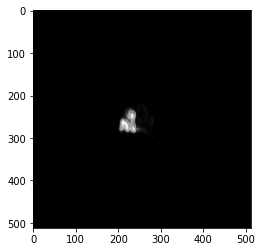

In [8]:
t=10

pred_img=model.predict(x_train[t:(t+1),...])

print (pred_img.shape)

plt.imshow(pred_img[0,:,:,0],cmap=plt.cm.gray)
plt.show()

# print (pred_img[0,:,:,0])
